In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [13]:
DEVICE = torch.device("cpu")
EPOCHS = 25
BATCH_SIZE = 64

In [14]:
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./.data',train=True,download=True,
                     transform=transforms.Compose([
                         transforms.RandomCrop(32, padding=4),
                         transforms.RandomHorizontalFlip(),
                         transforms.RandomRotation(10),
                         #데이터 증강 추가: RandomRotation(10도까지만 랜덤 회전)
                         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  
                         # 색깔 변화: 0.1씩 작은 변화
                         transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),
                                                                    (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR100('./.data',train=False,
                     transform=transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize((0.5, 0.5, 0.5),
                                              (0.5, 0.5, 0.5))])),
    batch_size=BATCH_SIZE, shuffle=True)


Files already downloaded and verified


In [15]:
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                                          nn.BatchNorm2d(planes)
)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [16]:
class CustomResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomResNet, self).__init__()
        self.in_planes = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        #block 개수 증가 -> 레이어 많은 학습
        self.layer1 = self._make_layer(16, 2, stride=1)
        self.layer2 = self._make_layer(32, 3, stride=2)
        self.layer3 = self._make_layer(64, 4, stride=2)
        self.linear = nn.Linear(64, 100)
    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [17]:
model = CustomResNet()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)


In [18]:
train_losses = []
test_losses = []

def train(model, train_loader, optimizer):
    model.train()
    total_loss=0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to('cpu'), target.to('cpu') 
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    

In [19]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to('cpu'), target.to('cpu')
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    test_losses.append(test_loss)
    return test_loss, test_accuracy


[1] Test Loss: 3.8157, Accuracy: 10.78%
[2] Test Loss: 3.4430, Accuracy: 16.96%
[3] Test Loss: 3.2853, Accuracy: 20.45%
[4] Test Loss: 2.8687, Accuracy: 27.85%
[5] Test Loss: 2.8283, Accuracy: 28.64%
[6] Test Loss: 2.7554, Accuracy: 31.06%
[7] Test Loss: 3.1553, Accuracy: 27.79%
[8] Test Loss: 2.4824, Accuracy: 35.96%
[9] Test Loss: 2.6863, Accuracy: 34.13%
[10] Test Loss: 2.6397, Accuracy: 35.17%
[11] Test Loss: 2.6931, Accuracy: 33.59%
[12] Test Loss: 2.7181, Accuracy: 34.85%
[13] Test Loss: 2.4329, Accuracy: 37.09%
[14] Test Loss: 2.7353, Accuracy: 33.85%
[15] Test Loss: 2.5584, Accuracy: 37.95%
[16] Test Loss: 3.6502, Accuracy: 28.14%
[17] Test Loss: 2.3996, Accuracy: 39.10%
[18] Test Loss: 2.5533, Accuracy: 36.86%
[19] Test Loss: 2.6448, Accuracy: 35.91%
[20] Test Loss: 2.2929, Accuracy: 41.13%
[21] Test Loss: 2.5699, Accuracy: 36.28%
[22] Test Loss: 2.3544, Accuracy: 40.33%
[23] Test Loss: 2.3648, Accuracy: 38.85%
[24] Test Loss: 2.2474, Accuracy: 41.88%
[25] Test Loss: 2.4232, A

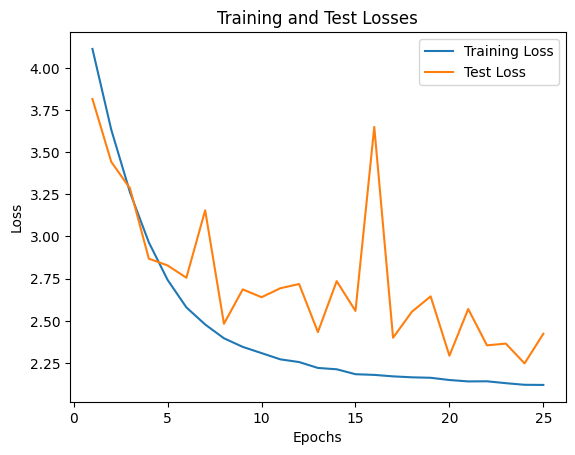

In [20]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    scheduler.step()
    print('[{}] Test Loss: {:.4f}, A ccuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))
    
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Losses')
plt.show()

In [21]:
PATH = 'model_customresnet.pth'
torch.save(model, PATH)